## Supervised Example (Bayesian Linear Regression)

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Normal
from edward.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-white'])
import itertools
# import matplotlib2tikz

import scipy
from scipy.stats import gaussian_kde

### Define helper function for simulating data

In [7]:
def build_toy_dataset(N, coeff=np.random.randn(10), noise_std=0.1):
  n_dim = len(coeff)
  x = np.random.randn(N, n_dim).astype(np.float32)
  y = np.dot(x, coeff) + norm.rvs(0, noise_std, size=N)
  return x, y

### Define size of dataset to simulate

In [23]:
ed.set_seed(42)

N = 500  # num data points
D = 5  # num features

# DATA
coeff = 10*(np.random.rand(D)-0.5)
X_train, y_train = build_toy_dataset(N, coeff)
X_test, y_test = build_toy_dataset(N, coeff)

RuntimeError: Seeding is not supported after initializing part of the graph. Please move set_seed to the beginning of your code.

### Plots (just to get a feel for simulated dataset)

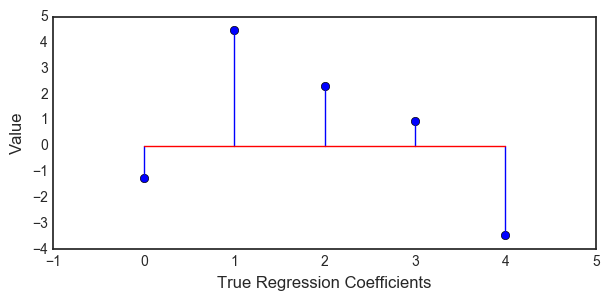

In [29]:
fig = plt.figure(figsize=(7,3))
ax = plt.subplot()

ax.stem(coeff, ms=8, mew=0)

ax.set_xlim([-1,D])
ax.set_xlabel("True Regression Coefficients")
ax.set_ylabel("Value")

gif = plt.plot 

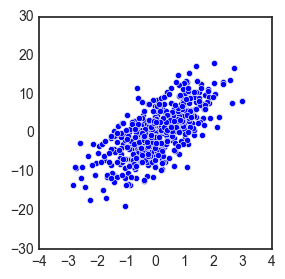

In [31]:
fig = plt.figure(figsize=(3,3))
ax = plt.subplot()

ax.scatter(X_train[:,1], y_train)

gif = plt.plot

### Define Bayesian Linear Regression Model

In [32]:
# MODEL
X = ed.placeholder(tf.float32, [N, D])
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

### Define Variational Approximating Distribution Families

In [13]:
# INFERENCE
qw = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

### RUN VARIATIONAL INFERENCE

In [14]:
data = {X: X_train, y: y_train}
inference = ed.MFVI({w: qw, b: qb}, data)
inference.run(n_samples=1, n_print=10, n_iter=1000)

Iteration    1 [  0%]: Loss = 11306.548
Iteration   10 [  1%]: Loss = 6780.600
Iteration   20 [  2%]: Loss = 2782.164
Iteration   30 [  3%]: Loss = 2115.363
Iteration   40 [  4%]: Loss = 708.605
Iteration   50 [  5%]: Loss = 732.695
Iteration   60 [  6%]: Loss = 588.625
Iteration   70 [  7%]: Loss = 600.949
Iteration   80 [  8%]: Loss = 573.269
Iteration   90 [  9%]: Loss = 524.892
Iteration  100 [ 10%]: Loss = 499.004
Iteration  110 [ 11%]: Loss = 513.538
Iteration  120 [ 12%]: Loss = 570.780
Iteration  130 [ 13%]: Loss = 512.762
Iteration  140 [ 14%]: Loss = 508.402
Iteration  150 [ 15%]: Loss = 510.888
Iteration  160 [ 16%]: Loss = 506.660
Iteration  170 [ 17%]: Loss = 503.761
Iteration  180 [ 18%]: Loss = 504.093
Iteration  190 [ 19%]: Loss = 511.178
Iteration  200 [ 20%]: Loss = 503.481
Iteration  210 [ 21%]: Loss = 513.098
Iteration  220 [ 22%]: Loss = 507.362
Iteration  230 [ 23%]: Loss = 514.235
Iteration  240 [ 24%]: Loss = 531.554
Iteration  250 [ 25%]: Loss = 502.578
Iterati

In [35]:
sess = ed.get_session()

print('Simulated regression coefficients: ')
print(coeff)
print()

print('Inferred regression coefficients (mean, std):')
print(sess.run(qw.mean()))
print(sess.run(qw.std()))
print()

print('Inferred bias: [should be close to zero]')
print(sess.run(qb.mean()))
print(sess.run(qb.std()))

Simulated regression coefficients: 
[-1.25459881  4.50714306  2.31993942  0.98658484 -3.4398136 ]

Inferred regression coefficients (mean, std):
[-1.24533546  4.49707174  2.32760596  0.96376288 -3.44824886]
[ 0.04969627  0.06415372  0.04796281  0.04822309  0.0527266 ]

Inferred bias: [should be close to zero]
[ 0.0114438]
[ 0.04549691]


### Posterior plots

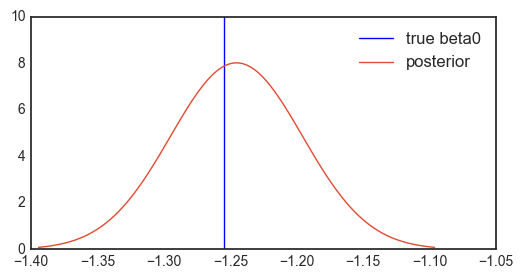

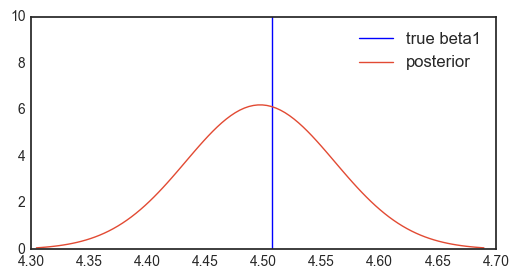

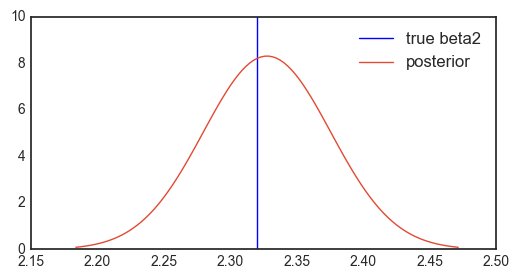

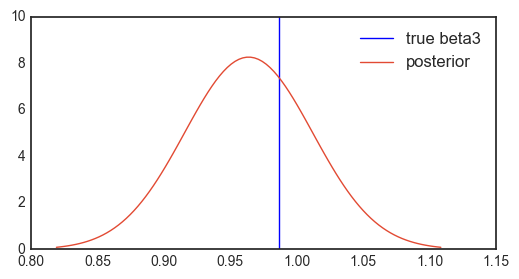

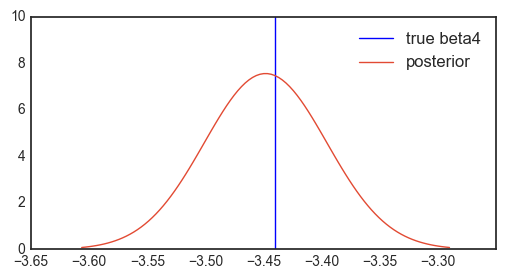

In [36]:
for index in np.arange(0,D):

    truth = coeff[index]
    post_mean = sess.run(qw.mean())[index]
    post_std = sess.run(qw.std())[index]

    xplot = np.linspace(post_mean-3*post_std, post_mean+3*post_std, 1e2)

    fig = plt.figure(figsize=(6,3))
    ax = plt.subplot()

    ax.axvline(truth, ymin=0, ymax=10, label='true beta'+str(index))
    ax.plot(xplot, scipy.stats.norm.pdf(xplot, loc=post_mean, scale=post_std), label='posterior')

    ax.legend(loc=1)
    ax.set_ylim([0, 10])

    gif = plt.plot

### Model Criticism (point-wise evaluations)

In [38]:
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
# This is equivalent to
# y_post = Normal(mu=ed.dot(X, qw.mean()) + qb.mean(), sigma=tf.ones(N))

print('Mean squared error on test data:')
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))
print()
print('Mean absolute error on test data:')
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0125724

Mean absolute error on test data:
0.0888485


### Posterior predictive checks

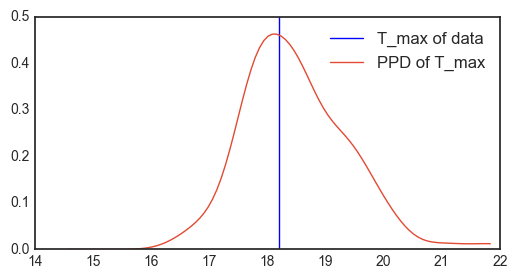

In [39]:
def T(xs, zs):
  return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_train, y_post: y_train})

T_of_data = ppc_max[1][0]

xplot = np.linspace(T_of_data-0.2*T_of_data, T_of_data+0.2*T_of_data, 1e2)

kernel = gaussian_kde(ppc_max[0])

fig = plt.figure(figsize=(6,3))
ax = plt.subplot()

ax.axvline(T_of_data, ymin=0, ymax=10, label='T_max of data')
ax.plot(xplot, kernel(xplot), label='PPD of T_max')

ax.legend(loc=1)

gif = plt.plot

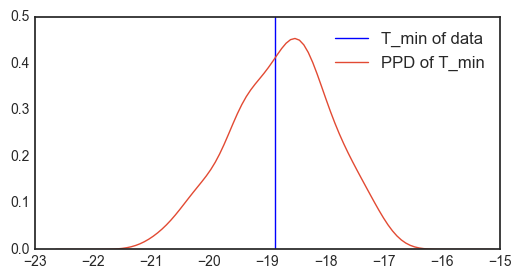

In [40]:
def T(xs, zs):
  return tf.reduce_min(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_train, y_post: y_train})

T_of_data = ppc_max[1][0]

xplot = np.linspace(T_of_data-0.2*T_of_data, T_of_data+0.2*T_of_data, 1e2)

kernel = gaussian_kde(ppc_max[0])

fig = plt.figure(figsize=(6,3))
ax = plt.subplot()

ax.axvline(T_of_data, ymin=0, ymax=10, label='T_min of data')
ax.plot(xplot, kernel(xplot), label='PPD of T_min')

ax.legend(loc=1)

gif = plt.plot

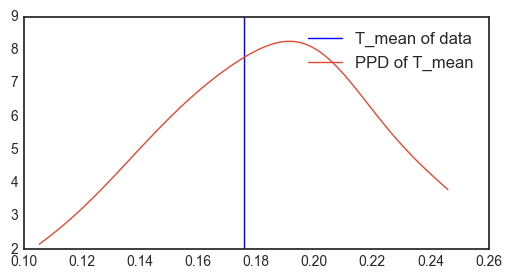

In [41]:
def T(xs, zs):
  return tf.reduce_mean(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_train, y_post: y_train})

T_of_data = ppc_max[1][0]

xplot = np.linspace(T_of_data-0.4*T_of_data, T_of_data+0.4*T_of_data, 1e2)

kernel = gaussian_kde(ppc_max[0])

fig = plt.figure(figsize=(6,3))
ax = plt.subplot()

ax.axvline(T_of_data, ymin=0, ymax=10, label='T_mean of data')
ax.plot(xplot, kernel(xplot), label='PPD of T_mean')

ax.legend(loc=1)

gif = plt.plot